# Traffic Signs Classification
Here i'm gonna be trying to classify traffic signs from crops that are going to be coming for a YOLO detector, since YOLO doesn't have much accuracy, but it detects traffic signs, I'm going to take the bounding box from YOLO, crop the image, and pass it through this classifier.

Let's see if it actually works **;)**

If you want to skip the set-up go to the [Model](#Model) section.

In [1]:
import os
import cv2
import json
import glob
import pickle
import random
import numpy as np
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt

import keras
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 6)

Using TensorFlow backend.


In [2]:
# Data path
data_path = 'data/20-classes/'

# Pickle files
train_pickle_file = 'train.p' 
valid_pickle_file = 'valid.p'

# Classes file
classes_file = 'classes.json'

In [3]:
# Load classes
with open(os.path.join(data_path, classes_file), mode='r') as json_file:
    classes = json.load(json_file)

In [4]:
# Load train data
train_file = open(os.path.join(data_path, train_pickle_file), 'rb')
train_data = pickle.load(train_file)

# Load valid data
valid_file = open(os.path.join(data_path, valid_pickle_file), 'rb')
valid_data = pickle.load(valid_file)

In [5]:
# Data shapes
print('Train data shape:', train_data['features'].shape)
print('Valid data shape:', valid_data['features'].shape)

Train data shape: (29676, 64, 64, 3)
Valid data shape: (12732, 64, 64, 3)


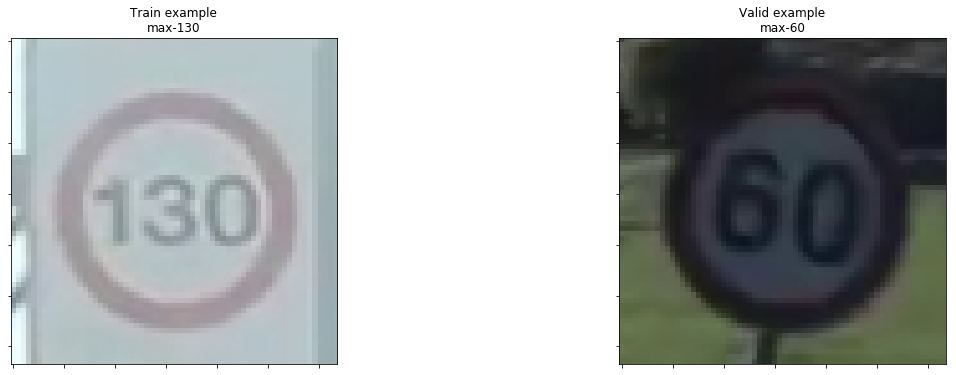

In [6]:
# Verify data
fig = plt.figure()

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

index = random.randrange(0, len(train_data['features']))
ax1.imshow(train_data['features'][index])
ax1.set_title('Train example\n' + classes[str(train_data['labels'][index])]['name'])
ax1.set_yticklabels([])
ax1.set_xticklabels([])

index = random.randrange(0, len(valid_data['features']))
ax2.imshow(valid_data['features'][index])
ax2.set_title('Valid example\n' + classes[str(valid_data['labels'][index])]['name'])
ax2.set_yticklabels([])
ax2.set_xticklabels([])

plt.show()

### Data convertion

In [7]:
NUM_CLASSES = len(classes.keys())
IMG_SIZE = 64

In [8]:
# Organize data
x_train = train_data['features']
y_train = train_data['labels']

x_valid = valid_data['features']
y_valid = valid_data['labels']

In [9]:
# Convert labels to one hot encoding
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_valid = keras.utils.to_categorical(y_valid, NUM_CLASSES)

# Model

In [10]:
# Checkpoint path
checkpoint_path = 'checkpoints/'

# Model name
model_name = 'model-1-20-classes-new'

In [11]:
from models.cnn_models import *

train_model = new_model_1_20()

In [12]:
from keras.optimizers import SGD

# Optimizer
#lr = 1e-2
#sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model
train_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [13]:
# Callbacks
filepath = model_name + '-weights-{epoch:02d}-{val_acc:.2f}.hdf5'
folder = os.path.join(checkpoint_path, model_name)
filepath = os.path.join(folder, filepath)

callbacks = [
                keras.callbacks.ModelCheckpoint(filepath, 
                                                monitor='val_acc', 
                                                verbose=0, 
                                                save_best_only=False, 
                                                save_weights_only=False, 
                                                mode='auto', 
                                                period=1),
                keras.callbacks.TensorBoard(log_dir='./logs/model-1-20-classes-new/', 
                                            histogram_freq=0, 
                                            write_graph=True, 
                                            write_images=False, 
                                            embeddings_freq=0, 
                                            embeddings_layer_names=None, 
                                            embeddings_metadata=None)
            ]

In [14]:
# Define model parameters
BATCH_SIZE = 256
EPOCHS = 64

In [ ]:
# Fit model
train_model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(x_valid, y_valid),
          callbacks=callbacks)

Train on 29676 samples, validate on 12732 samples
Epoch 1/64
29676/29676 [==============================] - 26s - loss: 2.2819 - acc: 0.2055 - val_loss: 1.8565 - val_acc: 0.2926

### Load test data

In [17]:
test_data_path = 'data/custom/'
test_pickle_file = 'test.p'

# Load valid data
test_file = open(os.path.join(test_data_path, test_pickle_file), 'rb')
test_data = pickle.load(test_file)

# Data shapes
print('Test data shape:', test_data['features'].shape)

x_test = test_data['features']
y_test = test_data['labels']

y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

Test data shape: (4620, 64, 64, 3)


### Obtain best model weights

In [18]:
# Evaluate model
file_filter = '*.hdf5'
folder = os.path.join(checkpoint_path, model_name)
weights_files = sorted(glob.glob(os.path.join(folder, file_filter)))

data = {}

for weight_file in tqdm_notebook(weights_files):
    # Load weights
    test_model = model(weights_path=weight_file)

    # Compile model
    test_model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

    # Evaluate model
    score = test_model.evaluate(x_test, y_test, verbose=0)

    data[weight_file] = {'test_loss': score[0], 'test_acc': score[1]}

In [19]:
max_acc = 0
max_acc_weights = None

for key in data.keys():
    if data[key]['test_acc'] > max_acc:
        max_acc = data[key]['test_acc']
        max_acc_weights = key
        
print(max_acc)
print(max_acc_weights)

0.508008658009
checkpoints/model-1-21-classes/model-1-21-classes-weights-08-0.95.hdf5


### Simple test on images

In [36]:
test_path = '/home/arian/Test'

files = glob.glob(os.path.join(test_path,'*.jpg'))
files.extend(glob.glob(os.path.join(test_path, '*.png')))

3.74237e-11
1.34881e-10
2.51992e-09
2.21341e-08
3.05511e-07
1.52191e-08
4.91883e-06
3.10745e-06
5.05298e-06
4.82082e-07
1.06437e-05
0.00792278
6.92038e-07
8.44853e-08
4.7529e-06
3.33241e-05
1.00718e-07
8.15051e-10
1.48504e-08
1.77944e-11
3.31849e-08
4.31567e-11
0.000331033
6.29101e-05
1.32565e-09
9.62656e-09
2.34306e-07
3.42071e-10


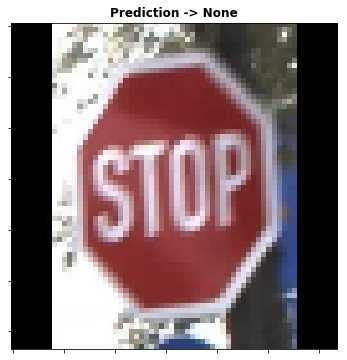

In [37]:
# Test on external image
image_path = files[1]
img = cv2.imread(image_path)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = img[...,::-1]

# Predict label for external test image
img_test = np.expand_dims(img, axis=0)
predictions = test_model.predict(img_test)[0]

for prediction in predictions:
    print(prediction)

class_id = np.argmax(predictions)

threshold = 0.1

if predictions[class_id] > threshold:
    class_label = classes[str(class_id)]
else:
    class_label = 'None'

# Plot image with class label
ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(img)
ax.set_title('Prediction -> ' + class_label, fontweight="bold")
plt.show()